In [1]:
import pandas as pd

# Load the CSV file
csv_file_path = "D:\Fall2023\Seminar\ALS KG Project\Code\pubmed_abstracts.csv" 
df = pd.read_csv(csv_file_path)
df.head()

,PMID,Abstract,PublishedYear
0,37975798,Amyotrophic lateral sclerosis (ALS) is a progr...,2023
1,37870685,Amyotrophic Lateral Sclerosis (ALS) is one of ...,2023
2,37768183,Increased amplitude of persistent inward curre...,2023
3,37752346,Amyotrophic lateral sclerosis (ALS) is a fatal...,2023
4,37566027,Amyotrophic lateral sclerosis (ALS) is an incu...,2023


In [2]:
df.isnull().any

<bound method DataFrame.any of       PMID  Abstract  PublishedYear
0    False     False          False
1    False     False          False
2    False     False          False
3    False     False          False
4    False     False          False
..     ...       ...            ...
100  False     False          False
101  False     False          False
102  False     False          False
103  False     False          False
104  False     False          False

[105 rows x 3 columns]>

#### Checking if there are no abstracts available in the "abstract" column

In [3]:
contains_no_abstract = df['Abstract'].str.contains('no abstract available', case=False)


if contains_no_abstract.any():
    print("\nRows with 'No abstract available':")
    print(df[contains_no_abstract])
else:
    print("\nNo rows with 'No abstract available'.")


Rows with 'No abstract available':
         PMID                Abstract  PublishedYear
59   29555890  No abstract available.           2018
100  23744890  No abstract available.           2013


In [4]:
df_filtered = df[~contains_no_abstract].copy()

# DataFrame after removing rows
print("\nDataFrame after removing rows with 'No abstract available':")
print(df_filtered.head())
print("length=",len(df_filtered))


DataFrame after removing rows with 'No abstract available':
       PMID                                           Abstract  PublishedYear
0  37975798  Amyotrophic lateral sclerosis (ALS) is a progr...           2023
1  37870685  Amyotrophic Lateral Sclerosis (ALS) is one of ...           2023
2  37768183  Increased amplitude of persistent inward curre...           2023
3  37752346  Amyotrophic lateral sclerosis (ALS) is a fatal...           2023
4  37566027  Amyotrophic lateral sclerosis (ALS) is an incu...           2023
length= 103


In [5]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [6]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def preprocess_text(text):
    # Replace "Amyotrophic lateral sclerosis" with "ALS"
    text = text.replace("Amyotrophic lateral sclerosis", "ALS")

    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Join the tokens back into a single string
    processed_text = ' '.join(tokens)
    
    return processed_text

# Apply text preprocessing to the 'Abstract' column
df_filtered['Cleaned_Abstract'] = df_filtered['Abstract'].apply(preprocess_text)

# Save the preprocessed data to a new CSV file
df_filtered.to_csv('preprocessed_abstracts.csv', index=False)


In [7]:
df = pd.read_csv('preprocessed_abstracts.csv')

In [8]:
from typing import List, Tuple, Dict

from openie import StanfordOpenIE

In [9]:
def preprocess_text(text: str) -> str:
    return re.sub(r'\s+', ' ', text)

#### Preprocess triples by concatenating subject, predicate, and object.

In [10]:
import spacy
from itertools import combinations

# Load the spaCy model
nlp = spacy.load("en_core_web_md")  

def pre_process(triples):
    
    return [" ".join([triple['subject'], triple['relation'], triple['object']]) for triple in triples]


#### Function to Recursively check if  similar triples are there.

In [11]:

def similarity_filter(triples):
    preprocessed_triple_docs = pre_process(triples)

    # Remove similar triples
    all_triple_pairs = list(combinations(preprocessed_triple_docs, 2))
    similar_triples = []
    for pair in all_triple_pairs:
        triple1 = nlp(pair[0])
        triple2 = nlp(pair[1])
        similarity = triple1.similarity(triple2)
        if similarity > 0.8:  
            similar_triples.append(pair)

    triples_to_remove = []
    for a_triple in similar_triples:
        index_for_removal = preprocessed_triple_docs.index(a_triple[0])
        triples_to_remove.append(index_for_removal)

    # Get indices of similar triples and remove them
    similar_triple_counts = set(triples_to_remove)
    similar_triples = [x[1] for x in enumerate(triples) if x[0] in similar_triple_counts]

    # Exit the recursion if there are no longer any similar triples
    if len(similar_triple_counts) == 0:
        return triples

    # Continue the recursion if there are still triples to remove
    else:
        # Remove similar triples from the next input
        for triple in similar_triples:
            idx = triples.index(triple)
            triples.pop(idx)
            
        return similarity_filter(triples)


#### Function to Check if two triples are similar based on their subjects and objects.
   

In [12]:
def is_similar(triple1, triple2):
    
    sub1, rel1, obj1 = triple1
    sub2, rel2, obj2 = triple2

    return (rel1 == rel2 and
            (sub1 in sub2 or sub2 in sub1) and
            (obj1 in obj2 or obj2 in obj1))

#### Filter out redundant and similar triples from the list of triples.

In [13]:
def filter_redundant_triples(triples: List[Dict[str, str]]) -> List[Dict[str, str]]:
    filtered_triples = []
    for triple in triples:
        triple_representation = (triple.get('subject', '').strip(),
                                 triple.get('relation', '').strip(),
                                 triple.get('object', '').strip())

        # Check if the triple or a similar one is already in the filtered list
        if not any(is_similar(triple_representation, (t.get('subject', '').strip(),
                                                       t.get('relation', '').strip(),
                                                       t.get('object', '').strip())) for t in filtered_triples):
            filtered_triples.append(triple)

    return filtered_triples

In [14]:
def extract_triples(text: str, properties: Dict[str, float], client: StanfordOpenIE) -> List[Dict[str, str]]:
    """
    Extract triples from the text using Stanford OpenIE.
    """
    preprocessed_text = preprocess_text(text)
    extracted_triples = client.annotate(preprocessed_text)
    return filter_redundant_triples(extracted_triples)

### A demo example with one abstract on how this algorithm is working?

In [29]:
properties = {'openie.affinity_probability_cap': 2 / 3}
client = StanfordOpenIE(properties)
text = "ALS is an adult-onset motor neuron disorder which is characterized by progressive motor symptoms, such as muscle weakness, muscle atrophy and spasticity. In Germany, 6000-8000 people are affected by ALS. Between 1200 and 1600 newly diagnosed patients are expected each year. Protein deposits in the cytoplasm of motor neurons are a molecular feature of ALS. The most common protein aggregates result from excessive deposition of TDP-43. Familial ALS is present in 5 to 10 % of all ALS patients. Common causal genes include C9orf72, SOD1, FUS, and TARDBP. Genetic factors may be involved even without a family history of ALS and may be underestimated. The disease course and progression are highly variable. Symptom severity and rate of progression are determined by the ALS Functional Scale (ALSFRS-R). Beyond clinical symptoms and the patient's perception of disease burden, measurement of slow vital capacity (SVC), peak cough flow (PCF), and body mass index (BMI) are used to underscore the indications for ventilatory and nutritional interventions, as well as palliative care. The validity of the biomarker neurofilament light chain (NF-L) for estimating prognosis is currently being investigated. ALS is not curable - however, various individual treatment options have to be considered for improving survival, symptom control and social participation. The care in specialized ALS centers is recommended to ensure optimal treatment regarding symptomatic medication, assistive devices, nutrition support and ventilation therapy. Optimal care is achieved by interdisciplinary collaboration of general practitioners, specialized physicians, neurologists and ALS experts being integrated in multiprofessional care networks"


triples = extract_triples(text, properties, client)

print("Extracted Triples:",end='\n')

for i in range(0,len(triples)):
    print(triples[i],end='\n')

Starting server with command: java -Xmx8G -cp C:\Users\gayat\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-524061b54cb44589.props -preload openie
Extracted Triples:
{'subject': 'ALS', 'relation': 'is', 'object': 'onset motor neuron disorder'}
{'subject': '6000 8000 people', 'relation': 'are affected by', 'object': 'ALS'}
{'subject': '6000 8000 people', 'relation': 'are', 'object': 'In Germany affected by ALS'}
{'subject': 'diagnosed patients', 'relation': 'are expected at_time', 'object': 'year'}
{'subject': 'Protein deposits', 'relation': 'is in', 'object': 'cytoplasm of motor neurons'}
{'subject': 'Protein deposits', 'relation': 'are', 'object': 'molecular feature'}
{'subject': 'deposits', 'relation': 'are molecular', 'object': 'ALS'}
{'subject': 'Protein deposits', 'relation': 'are molecular feature of', 'object': 'ALS'}
{'subject'

### Filtering semantically same Triples

In [30]:

refined_triples = similarity_filter(triples)

print("Semantically Refined triples:",end='\n')
for i in range(0,len(refined_triples)):
    print(refined_triples[i],end='\n')

Semantically Refined triples:
{'subject': 'ALS', 'relation': 'is', 'object': 'onset motor neuron disorder'}
{'subject': '6000 8000 people', 'relation': 'are', 'object': 'In Germany affected by ALS'}
{'subject': 'diagnosed patients', 'relation': 'are expected at_time', 'object': 'year'}
{'subject': 'Protein deposits', 'relation': 'are feature of', 'object': 'ALS'}
{'subject': 'common protein aggregates', 'relation': 'result from', 'object': 'deposition of TDP 43'}
{'subject': 'Familial ALS', 'relation': 'is present in', 'object': '5 to 10 % of ALS patients'}
{'subject': 'Common genes', 'relation': 'include', 'object': 'C9orf72'}
{'subject': 'Genetic factors', 'relation': 'be', 'object': 'underestimated'}
{'subject': 'patient', 'relation': 'has', 'object': 'perception of disease burden'}
{'subject': 'measurement', 'relation': 'underscore', 'object': 'indications'}
{'subject': 'measurement', 'relation': 'are', 'object': 'used'}
{'subject': 'care', 'relation': 'is in', 'object': 'specializ

#### Checking the count of extracted  triples and filtered triples.

In [19]:
properties = {'openie.affinity_probability_cap': 2 / 3}
client = StanfordOpenIE(properties)
unique_triples = []
# Iterate over each abstract in the DataFrame
for index, row in df.iterrows():
    text = row['Abstract']  # Adjust column name if necessary

    triples = extract_triples(text, properties, client)
    print(f"Extracted triples count for abstract {index}: {len(triples)}",end='\n')
    
        # Filter out semantically similar triples
    filtered_triples = similarity_filter(triples)
    unique_triples.append(filtered_triples)
    print(f"filtered triples count for abstract {index}: {len(filtered_triples)}",end='\n')

Starting server with command: java -Xmx8G -cp C:\Users\gayat\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-f41ca84ccf174d3a.props -preload openie
Extracted triples count for abstract 0: 18
filtered triples count for abstract 0: 7
Extracted triples count for abstract 1: 10
filtered triples count for abstract 1: 6
Extracted triples count for abstract 2: 76
filtered triples count for abstract 2: 12
Extracted triples count for abstract 3: 10
filtered triples count for abstract 3: 6
Extracted triples count for abstract 4: 30
filtered triples count for abstract 4: 12
Extracted triples count for abstract 5: 27
filtered triples count for abstract 5: 10
Extracted triples count for abstract 6: 46
filtered triples count for abstract 6: 9
Extracted triples count for abstract 7: 11
filtered triples count for abstract 7: 7
Extracted triples count f

In [20]:
temp=[]
for i in unique_triples:
    temp.extend(i)
print("count of extracted triples:",len(temp))

count of extracted triples: 898


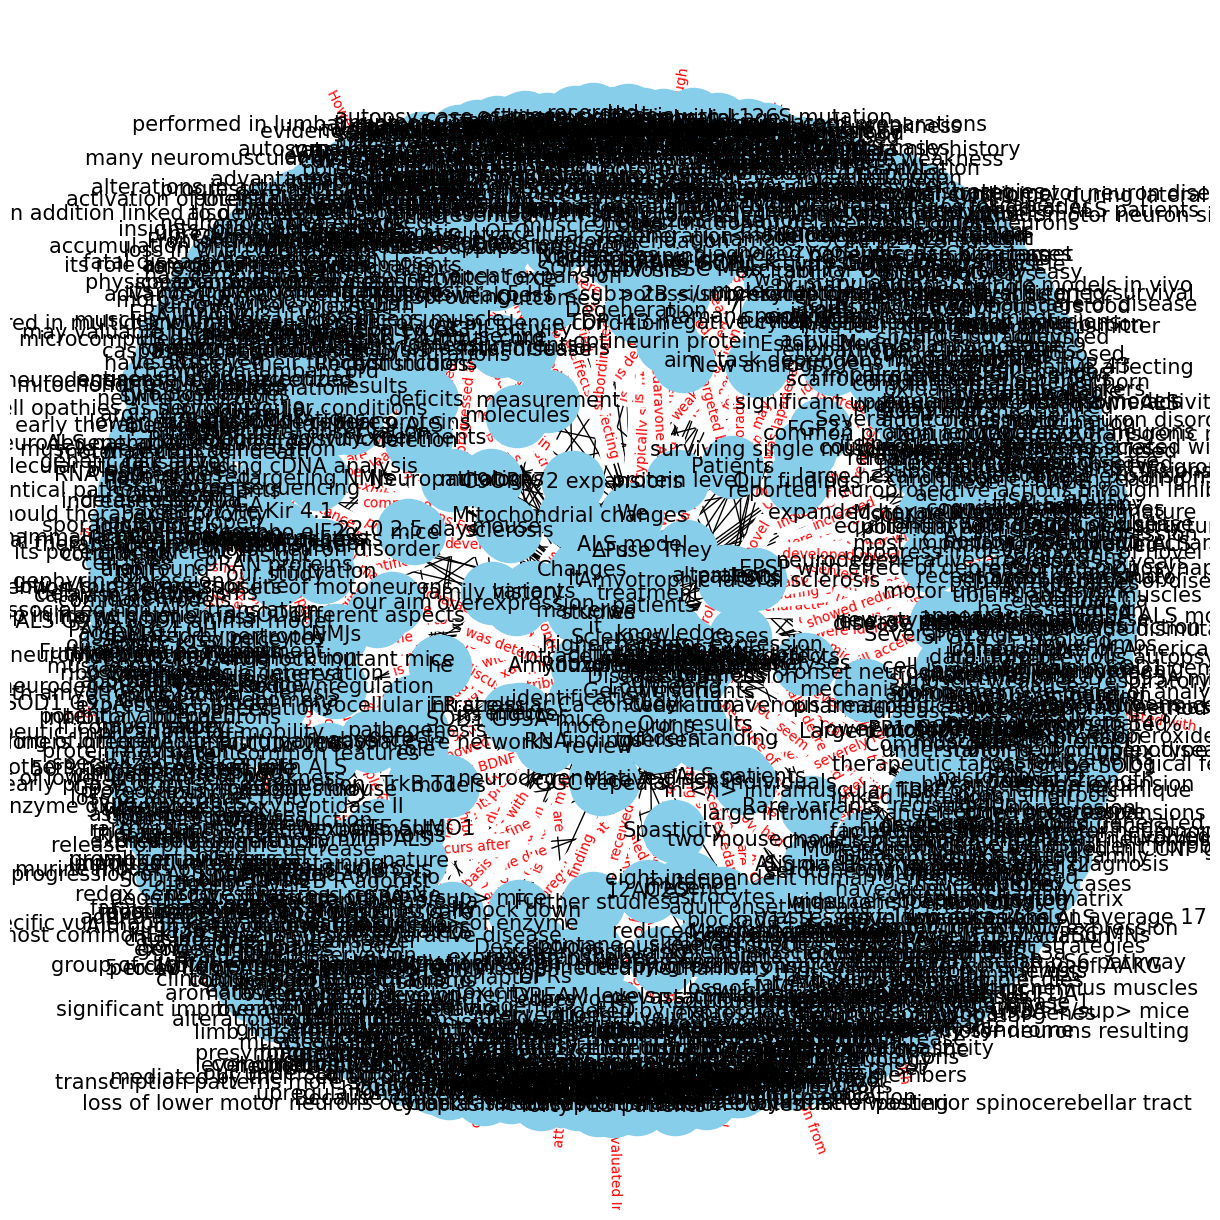

In [22]:
import networkx as nx
import matplotlib.pyplot as plt

triples=temp

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for triple in triples:
    subj, rel, obj = triple['subject'], triple['relation'], triple['object']
    G.add_node(subj)
    G.add_node(obj)
    G.add_edge(subj, obj, label=rel)

# Graph visualization
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)  # Positioning of the nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='black', linewidths=1, font_size=15)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'), font_color='red')
plt.show()

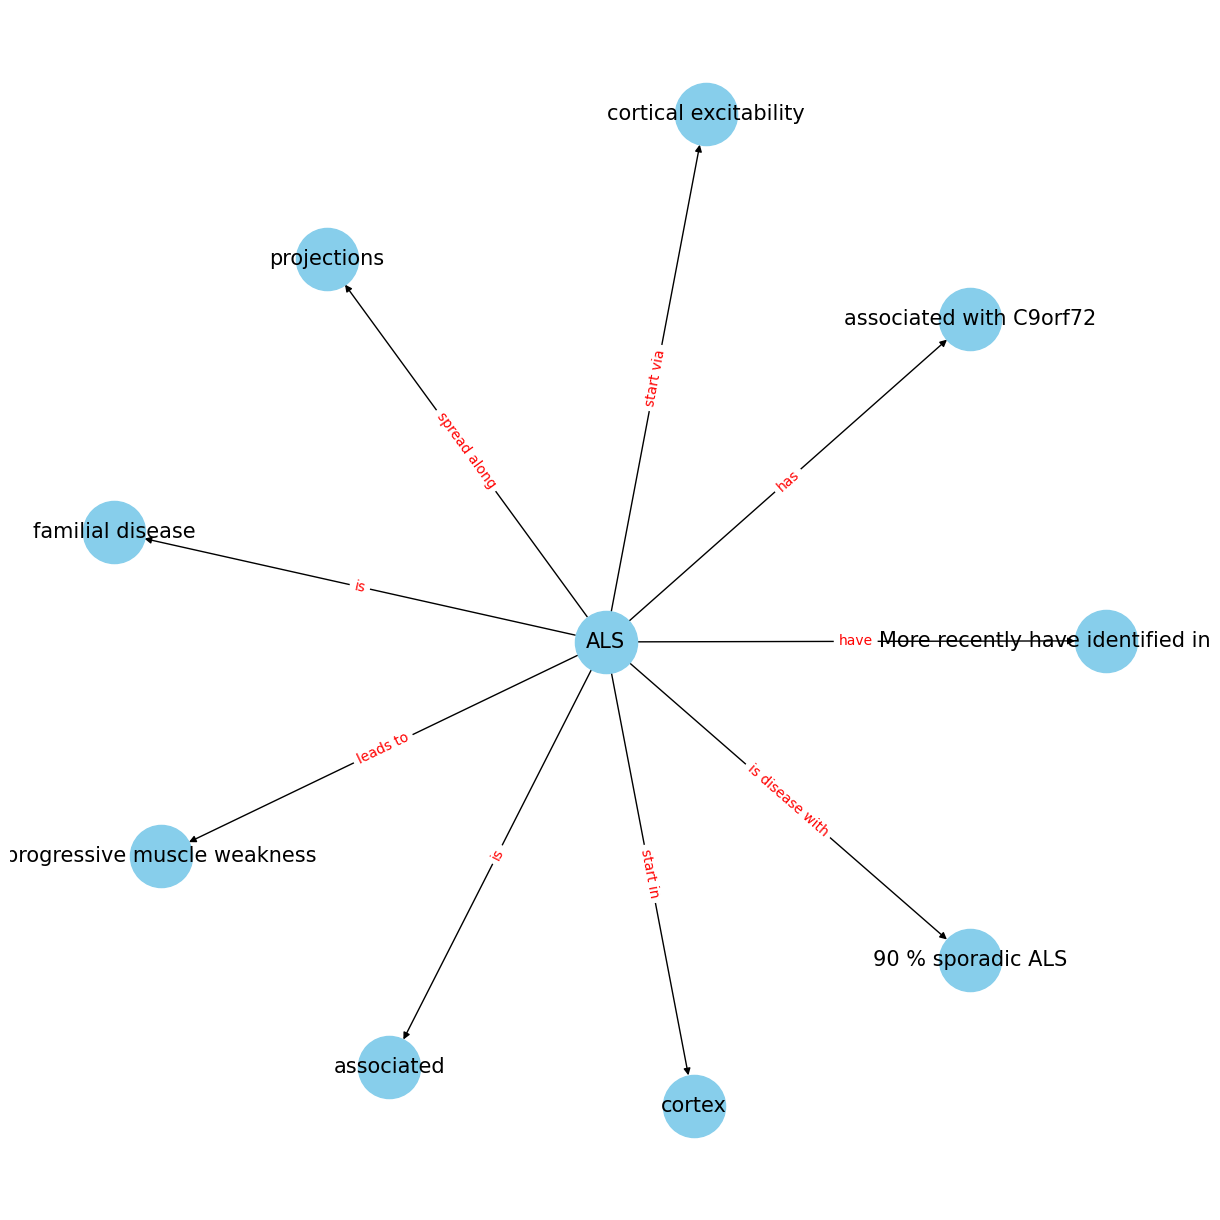

In [28]:
selected_subjects = {'ALS'}  


G = nx.DiGraph()


for triple in triples:
    subj, rel, obj = triple['subject'], triple['relation'], triple['object']
    if subj in selected_subjects:
        G.add_node(subj)
        G.add_node(obj)
        G.add_edge(subj, obj, label=rel)


plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='black', linewidths=1, font_size=15)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'), font_color='red')
plt.show()

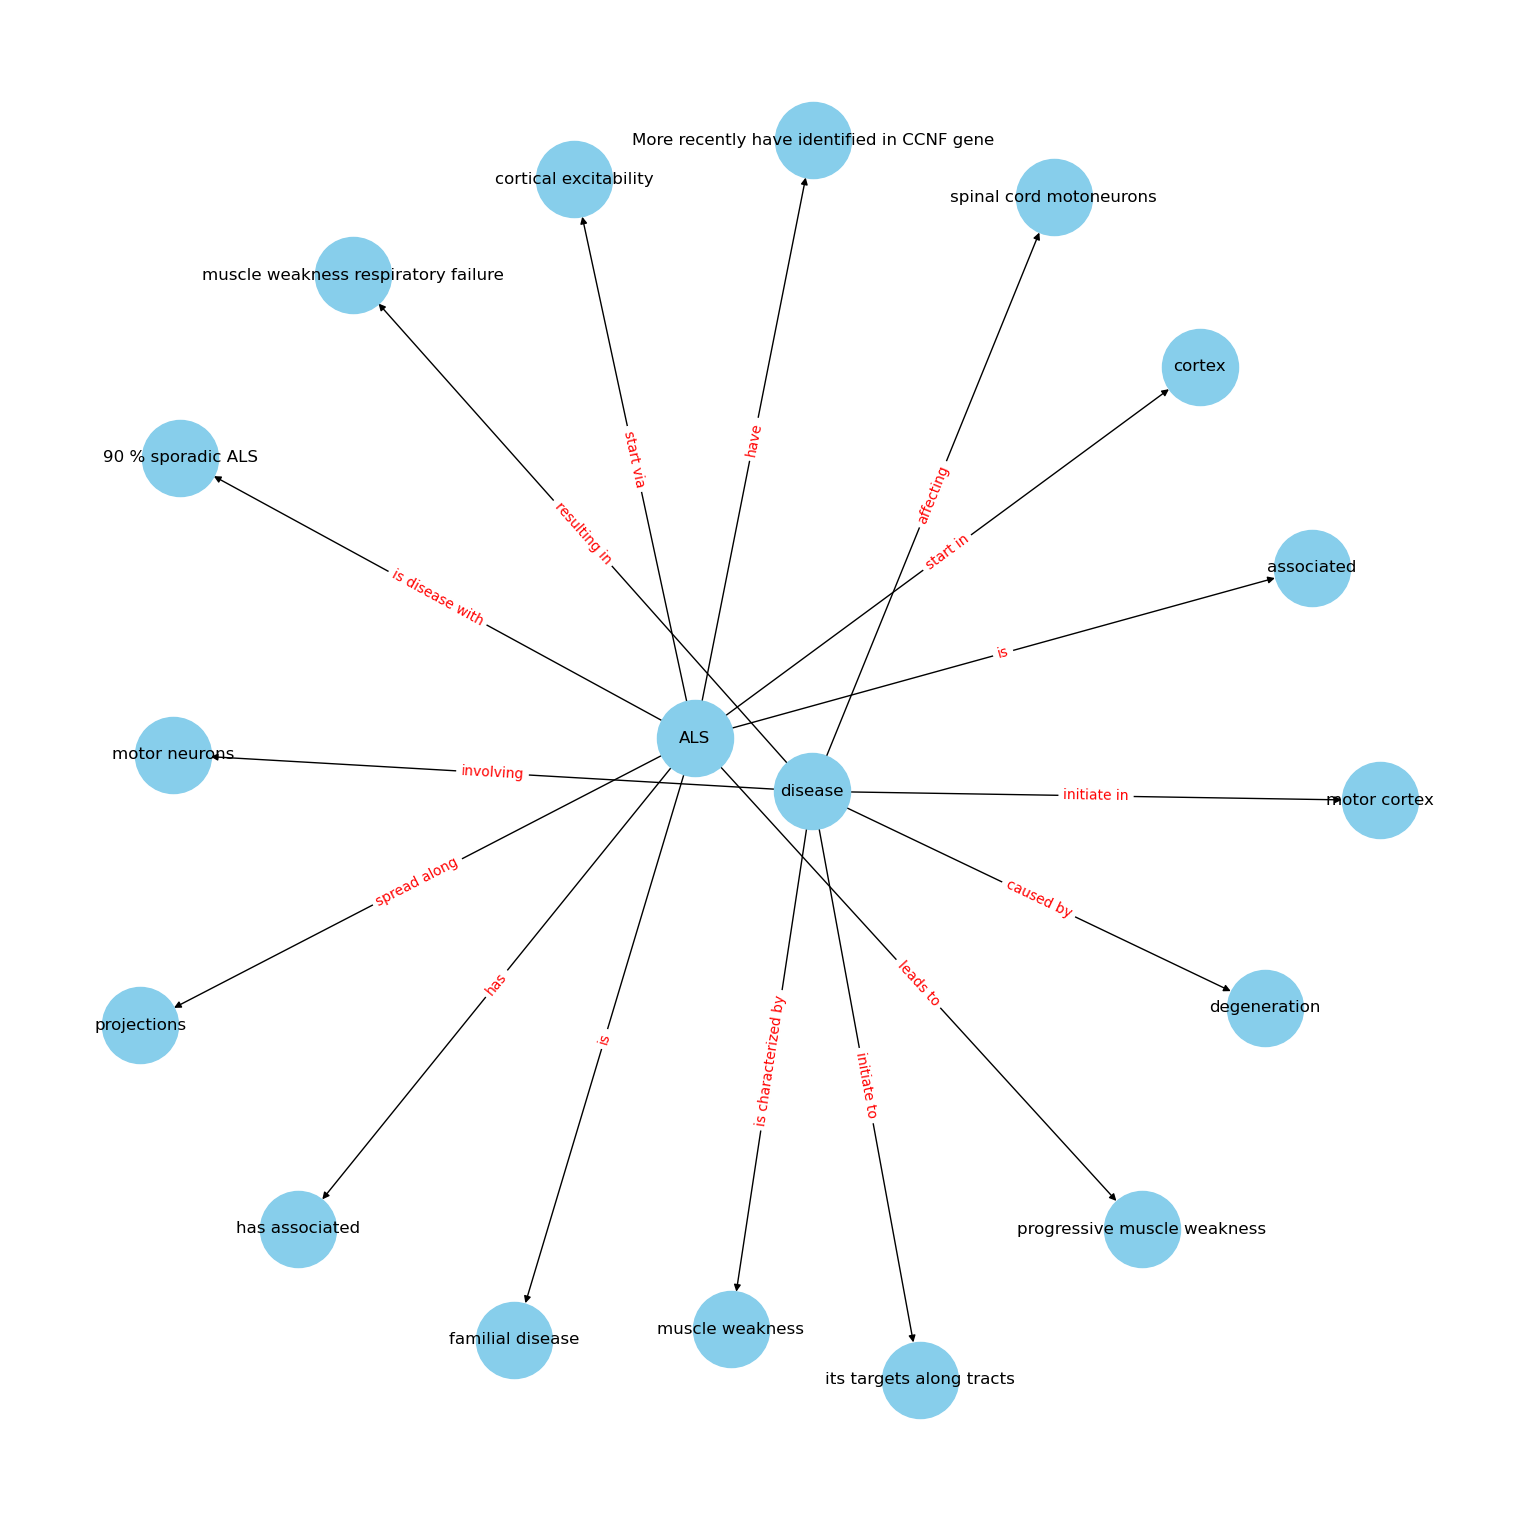

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

selected_subjects = {'ALS','disease'}  


G = nx.DiGraph()


for triple in triples:
    subj, rel, obj = triple['subject'], triple['relation'], triple['object']
    obj_label = '\n'.join([obj[i:i+30] for i in range(0, len(obj), 30)]) 
    if subj in selected_subjects:
        G.add_node(subj)
        G.add_node(obj)
        G.add_edge(subj, obj, label=rel)

plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=3000, edge_color='black', linewidths=1, font_size=12)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'), font_color='red')
plt.show()

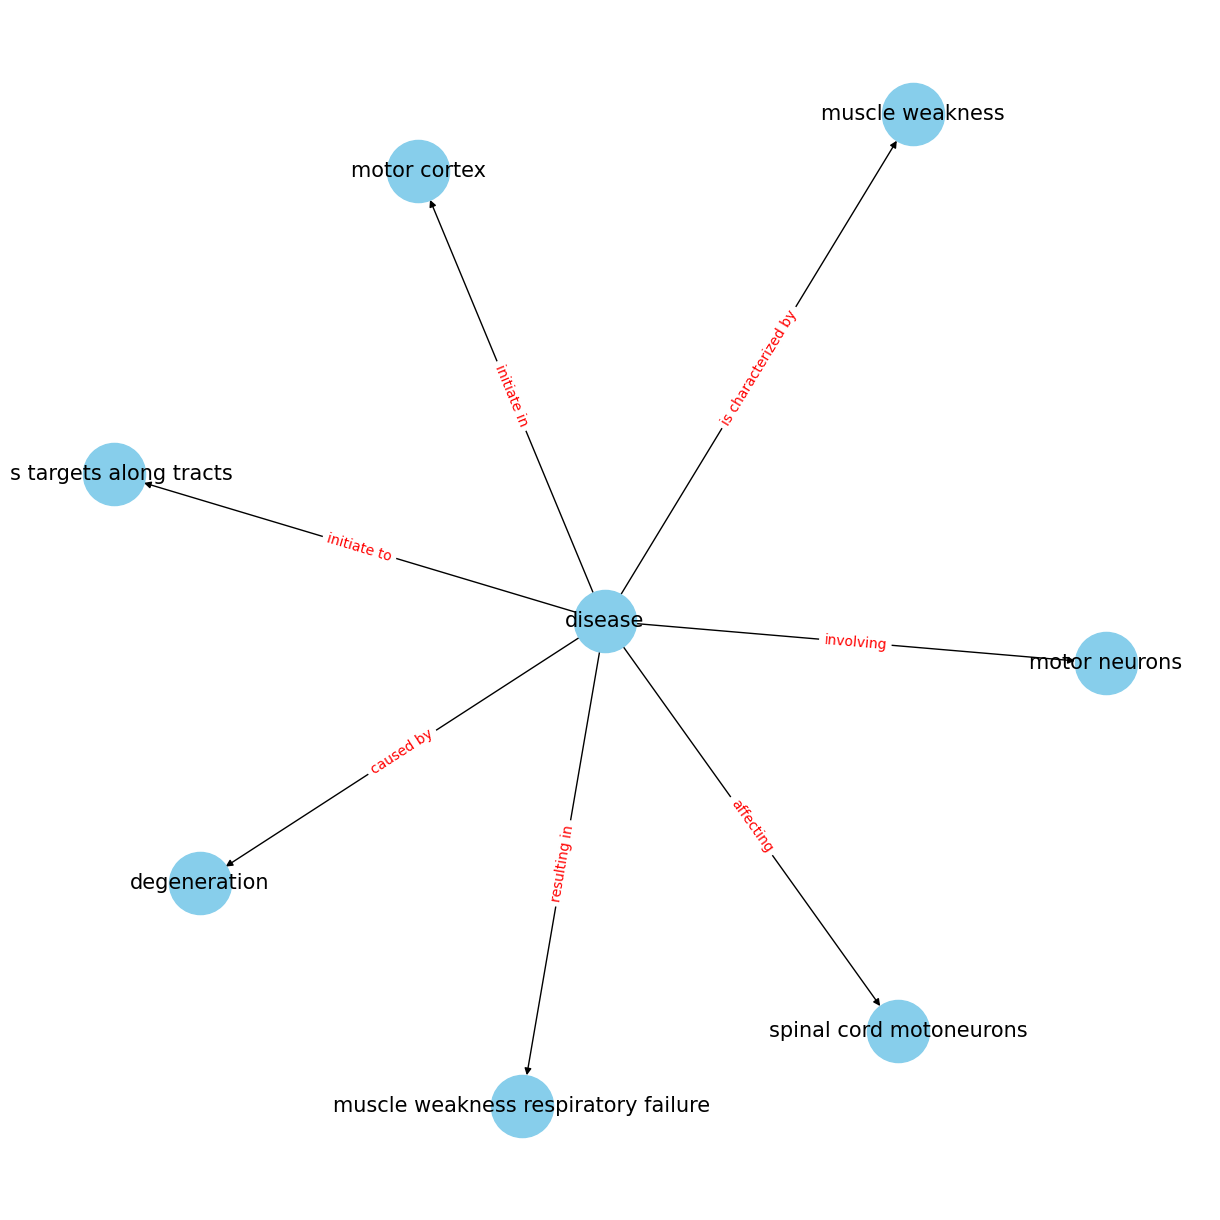

In [38]:
selected_subjects = {'disease'} 

G = nx.DiGraph()


for triple in triples:
    subj, rel, obj = triple['subject'], triple['relation'], triple['object']
    if subj in selected_subjects:
        G.add_node(subj)
        G.add_node(obj)
        G.add_edge(subj, obj, label=rel)


plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='black', linewidths=1, font_size=15)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'), font_color='red')
plt.show()

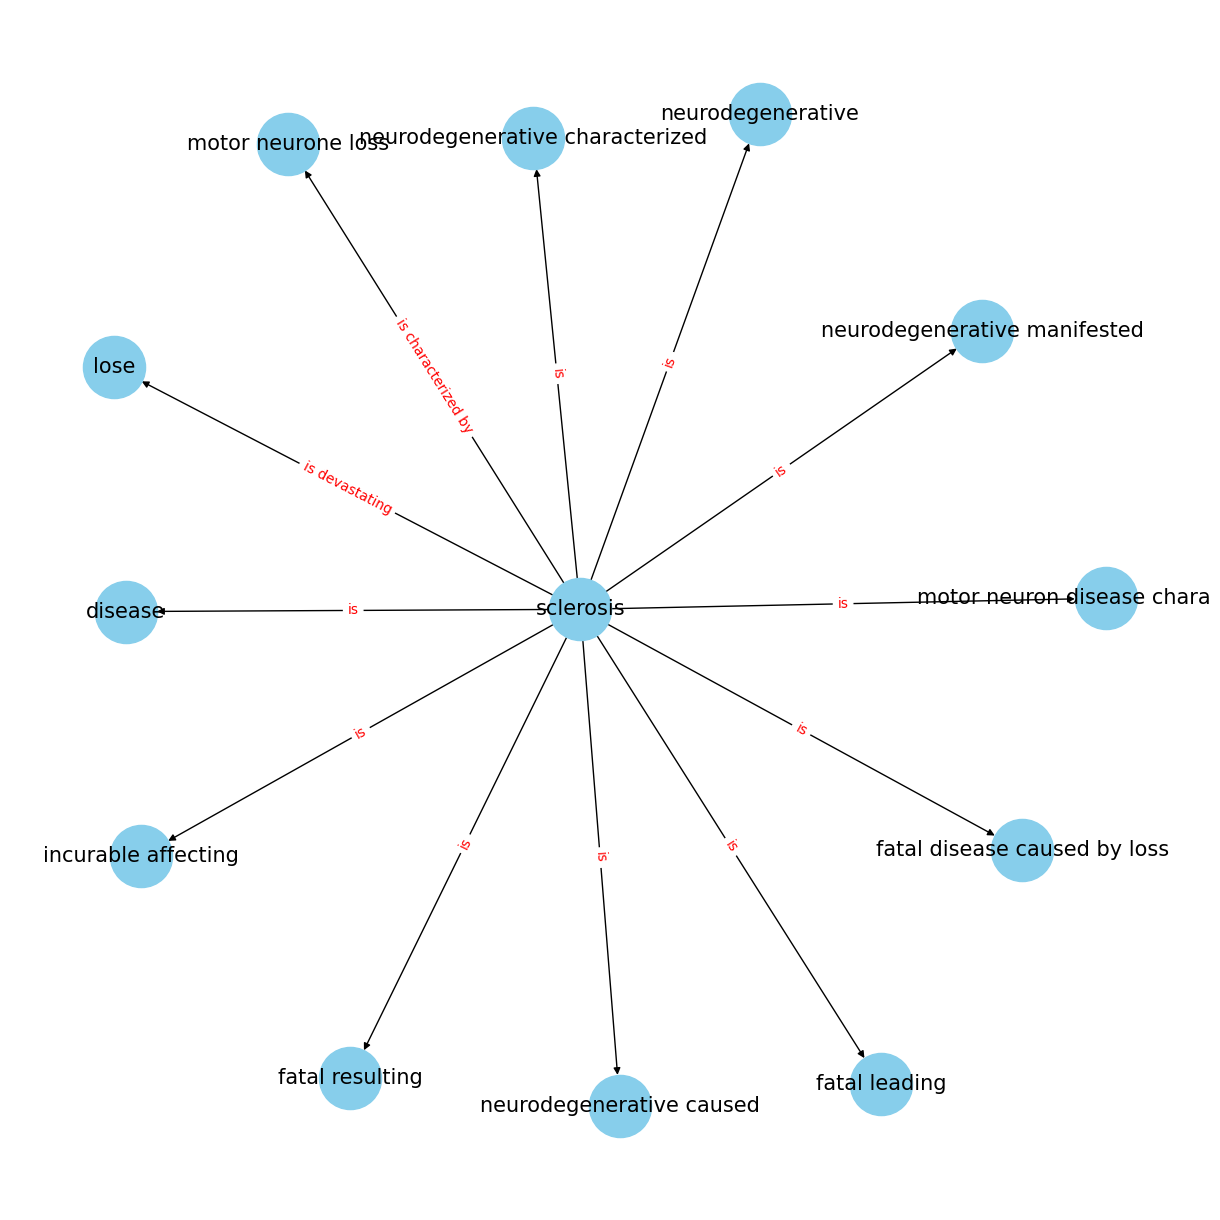

In [37]:
selected_subjects = {'sclerosis'}  


G = nx.DiGraph()

for triple in triples:
    subj, rel, obj = triple['subject'], triple['relation'], triple['object']
    if subj in selected_subjects:
        G.add_node(subj)
        G.add_node(obj)
        G.add_edge(subj, obj, label=rel)


plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G) 
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='black', linewidths=1, font_size=15)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'), font_color='red')
plt.show()

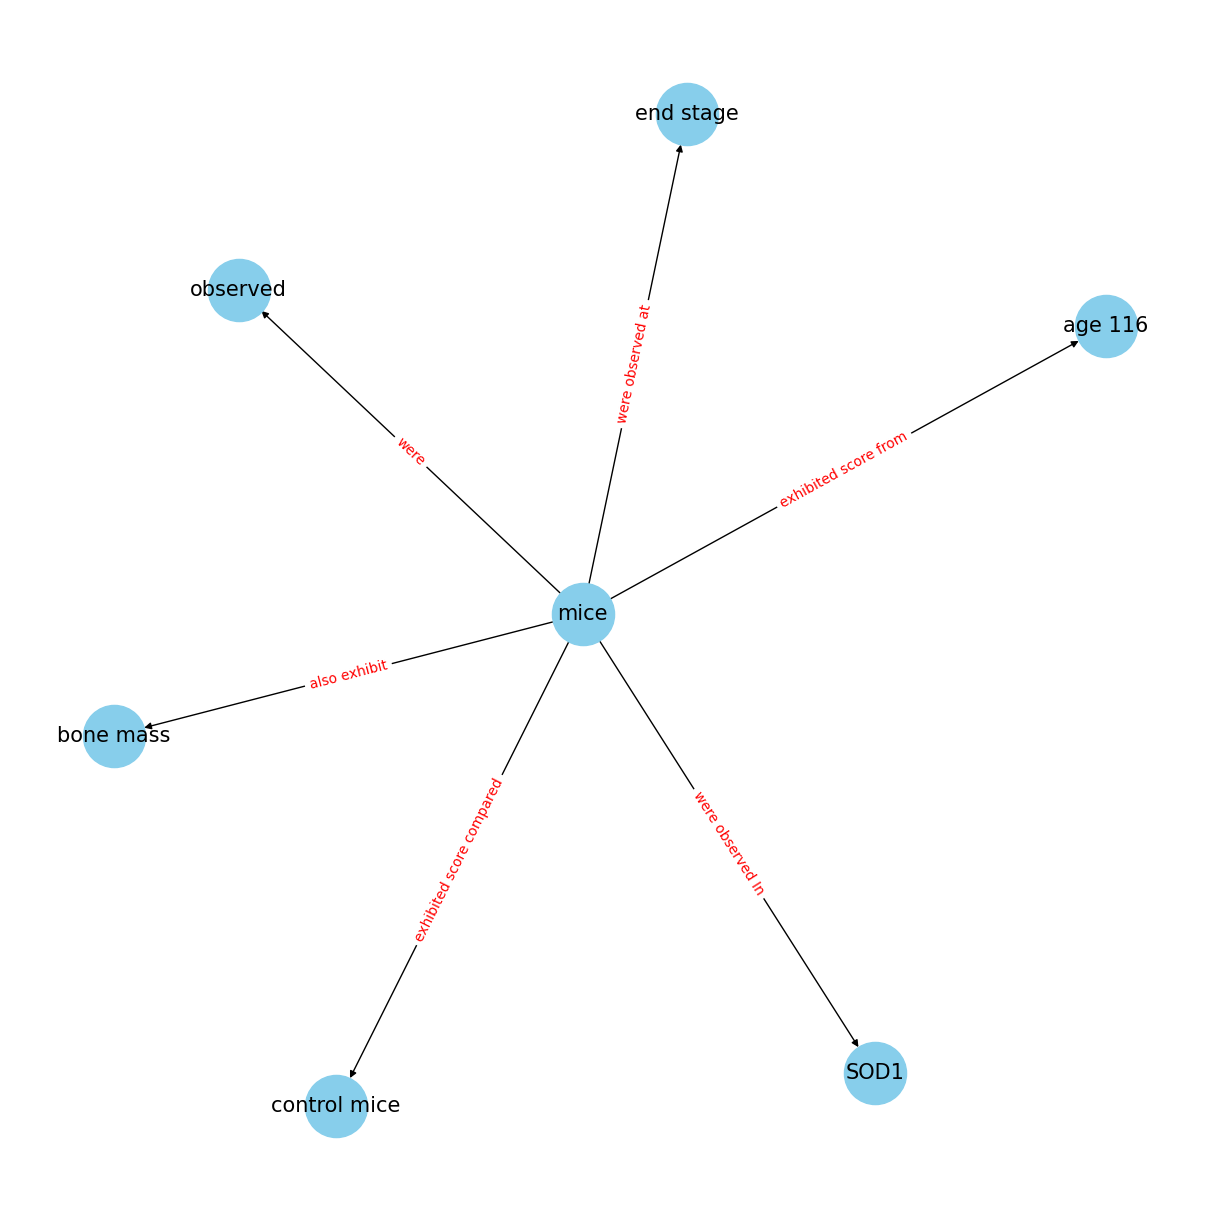

In [39]:
selected_subjects = {'mice'}  

G = nx.DiGraph()


for triple in triples:
    subj, rel, obj = triple['subject'], triple['relation'], triple['object']
    if subj in selected_subjects:
        G.add_node(subj)
        G.add_node(obj)
        G.add_edge(subj, obj, label=rel)


plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='black', linewidths=1, font_size=15)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'), font_color='red')
plt.show()

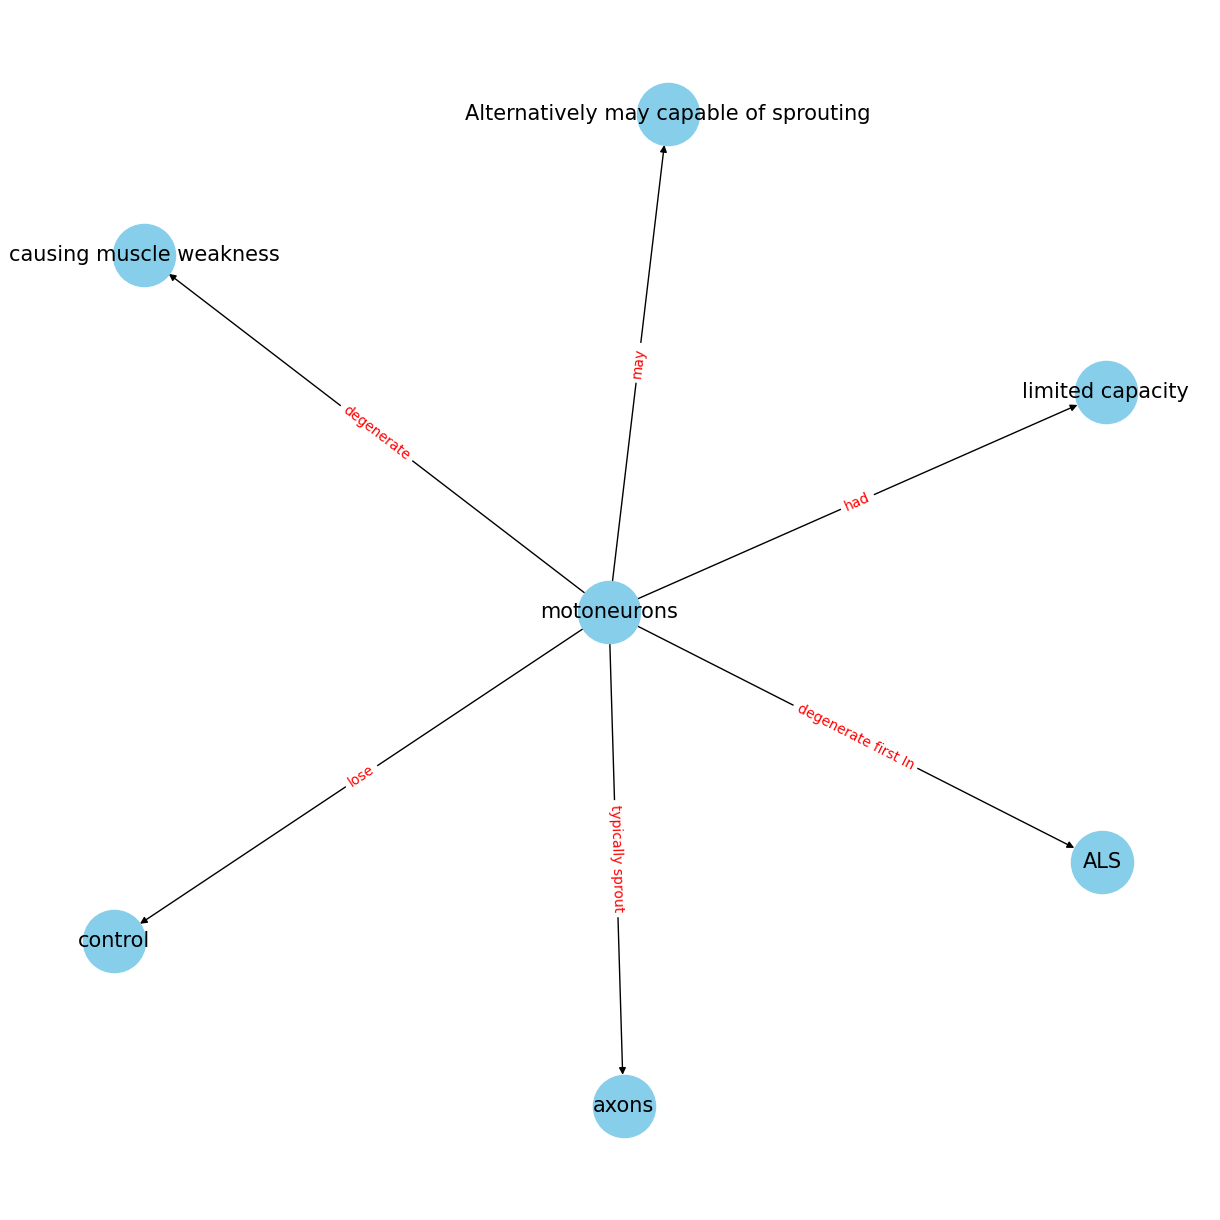

In [41]:
selected_subjects = {'motoneurons'}  
G = nx.DiGraph()

for triple in triples:
    subj, rel, obj = triple['subject'], triple['relation'], triple['object']
    if subj in selected_subjects:
        G.add_node(subj)
        G.add_node(obj)
        G.add_edge(subj, obj, label=rel)


plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G) 
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='black', linewidths=1, font_size=15)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'), font_color='red')
plt.show()

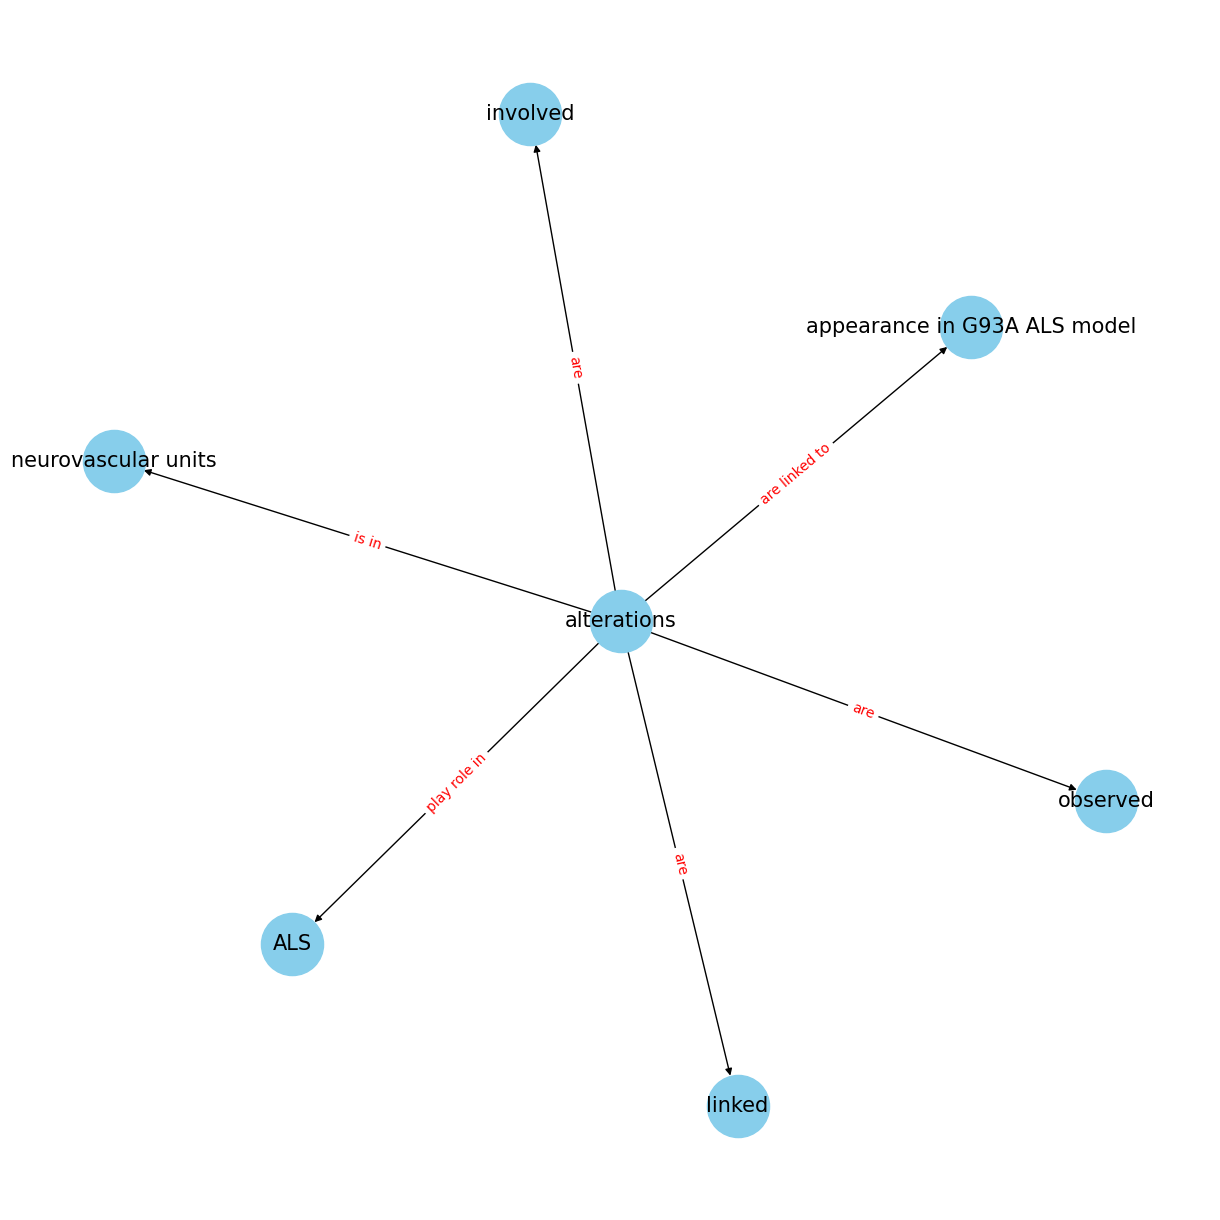

In [42]:
selected_subjects = {'alterations'}  

G = nx.DiGraph()


for triple in triples:
    subj, rel, obj = triple['subject'], triple['relation'], triple['object']
    if subj in selected_subjects:
        G.add_node(subj)
        G.add_node(obj)
        G.add_edge(subj, obj, label=rel)


plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='black', linewidths=1, font_size=15)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'), font_color='red')
plt.show()